In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
%matplotlib inline

In [2]:
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro)
    df      = pd.read_csv(acc)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df



In [3]:

acc_file = 'data/Bike2308/2018-08-23_16-18-07/AccelerometerLinear.csv'
gyro_file= 'data/Bike2308/2018-08-23_16-18-07/Gyroscope.csv'

df = read_csv_file(acc_file, gyro_file, 'bike')
print("shape -", df.shape)


shape - (14413, 8)


In [4]:
df = df[2000:13000]
print("shape -", df.shape)
df.head()

shape - (11000, 8)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity
2000,40002,0.288216,-0.082069,1.302227,0.098831,0.019287,-0.075989,bike
2001,40021,-0.558016,-0.951754,-0.116348,0.091370,0.052307,-0.086639,bike
2002,40041,-0.985235,0.982713,1.306730,-0.038589,0.107697,-0.034439,bike
2003,40061,-0.616953,-0.054531,0.906866,0.218140,0.266434,0.053986,bike
2004,40081,0.062307,-0.536265,-3.523378,0.079651,-0.027588,0.126419,bike


In [5]:
# df['user'].value_counts().plot(kind = 'bar', title = 'counts of activities')

In [6]:
def plot_transportation_mod(transportation_mode, df):
    data = df[df['activity'] == transportation_mode][['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ']][:8000]
    
    axis = data.plot(subplots = True, figsize =(20, 20), title = transportation_mode)
    
    for ax in axis:
        ax.legend(loc = 'lower left', bbox_to_anchor=(1.0,0.5))

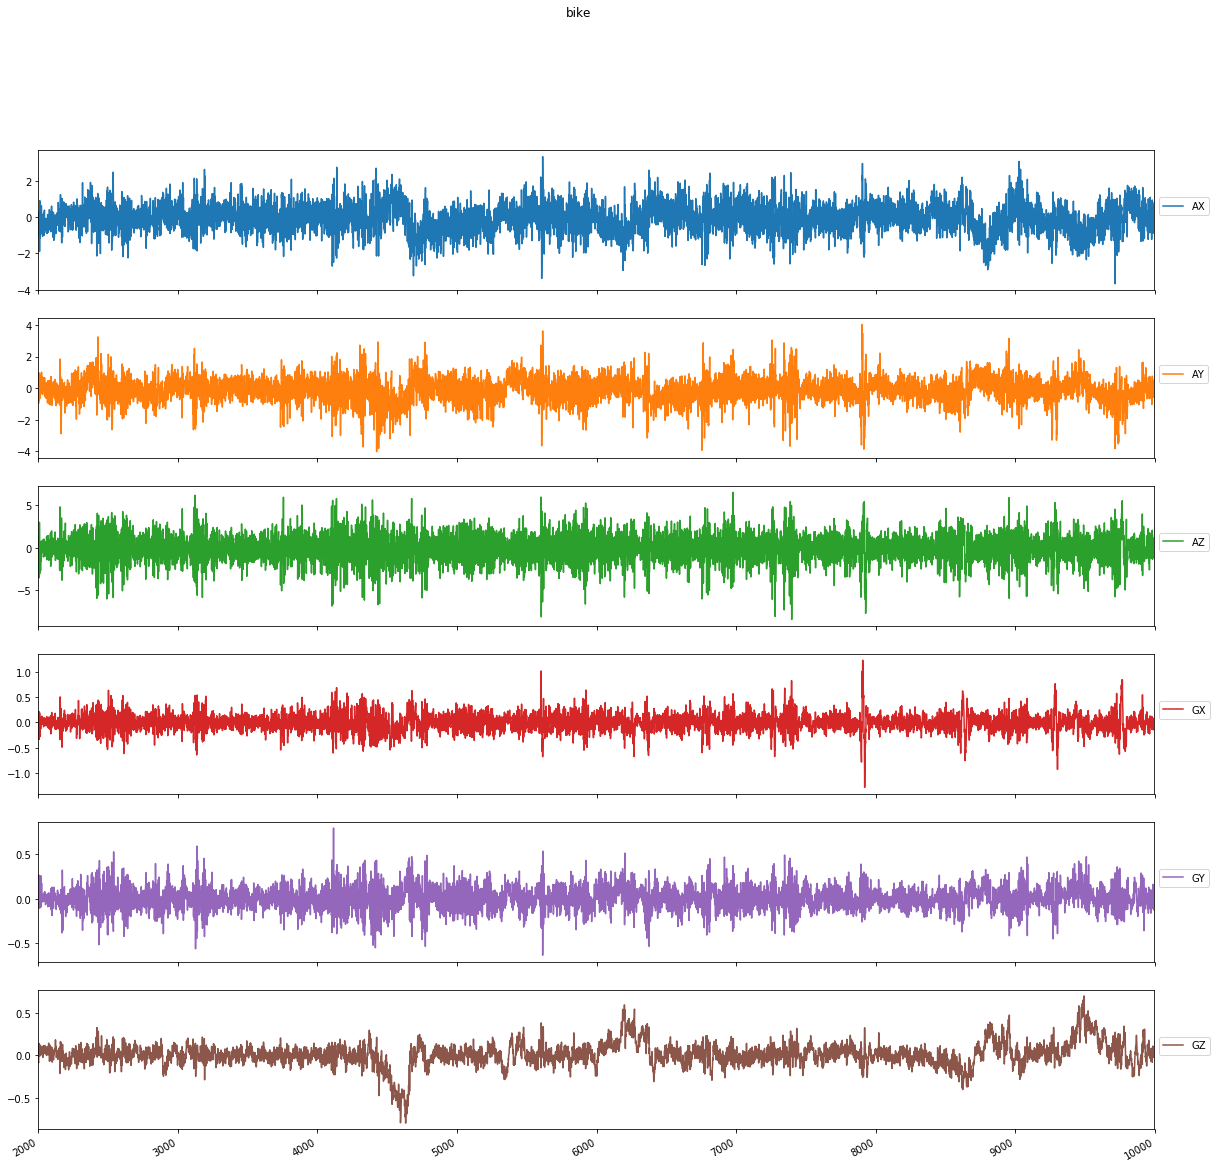

In [7]:
plot_transportation_mod('bike', df)

In [8]:
# df['GZ'].plot(figsize=(20,5),title="Z-axis of gyro for Motor-bike")

In [9]:
acc_file = 'data/Bike2308/2018-08-23_15-53-43/AccelerometerLinear.csv'
gyro_file= 'data/Bike2308/2018-08-23_15-53-43/Gyroscope.csv'

df = read_csv_file(acc_file, gyro_file, 'bike')
print("shape -", df.shape)


shape - (7778, 8)


In [10]:
df = df[1250:-500]
print("shape -", df.shape)
df.head()

shape - (6028, 8)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity
1250,25001,-0.390852,-0.694147,1.033067,0.010406,0.090652,-0.111130,bike
1251,25020,-0.302526,-0.277619,1.104467,0.064743,0.178009,-0.119659,bike
1252,25041,0.067222,-0.487969,-0.251655,0.073257,-0.009476,-0.065323,bike
1253,25060,-0.167626,-0.268813,-0.725385,-0.108902,-0.026520,-0.011002,bike
1254,25080,-0.424845,0.358878,1.375887,-0.057770,0.092789,-0.007812,bike


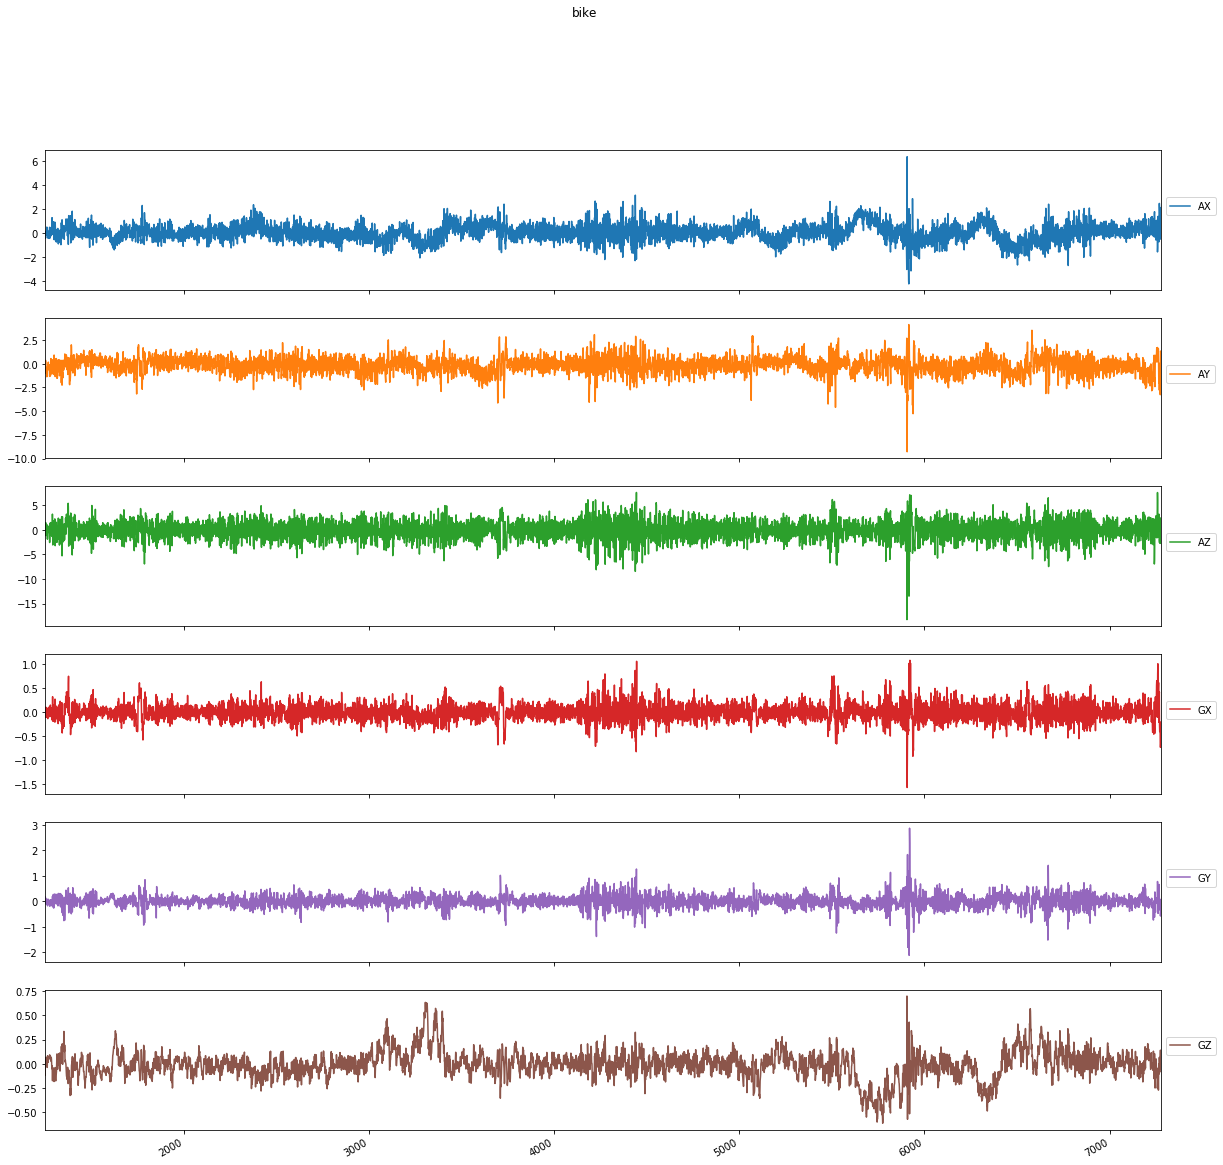

In [11]:
plot_transportation_mod('bike', df)

In [12]:
# df['GZ'].plot(figsize=(20,5),title="Z-axis of gyro for Motor-bike")

In [13]:

window_length = 10
df1 = df
df1['AX'] = gaussian_filter(df['AX'], window_length)
df1['AY'] = gaussian_filter(df['AY'], window_length)
df1['AZ'] = gaussian_filter(df['AZ'], window_length)

df1['GX'] = gaussian_filter(df['GX'], window_length)
df1['GY'] = gaussian_filter(df['GY'], window_length)
df1['GZ'] = gaussian_filter(df['GZ'], window_length)


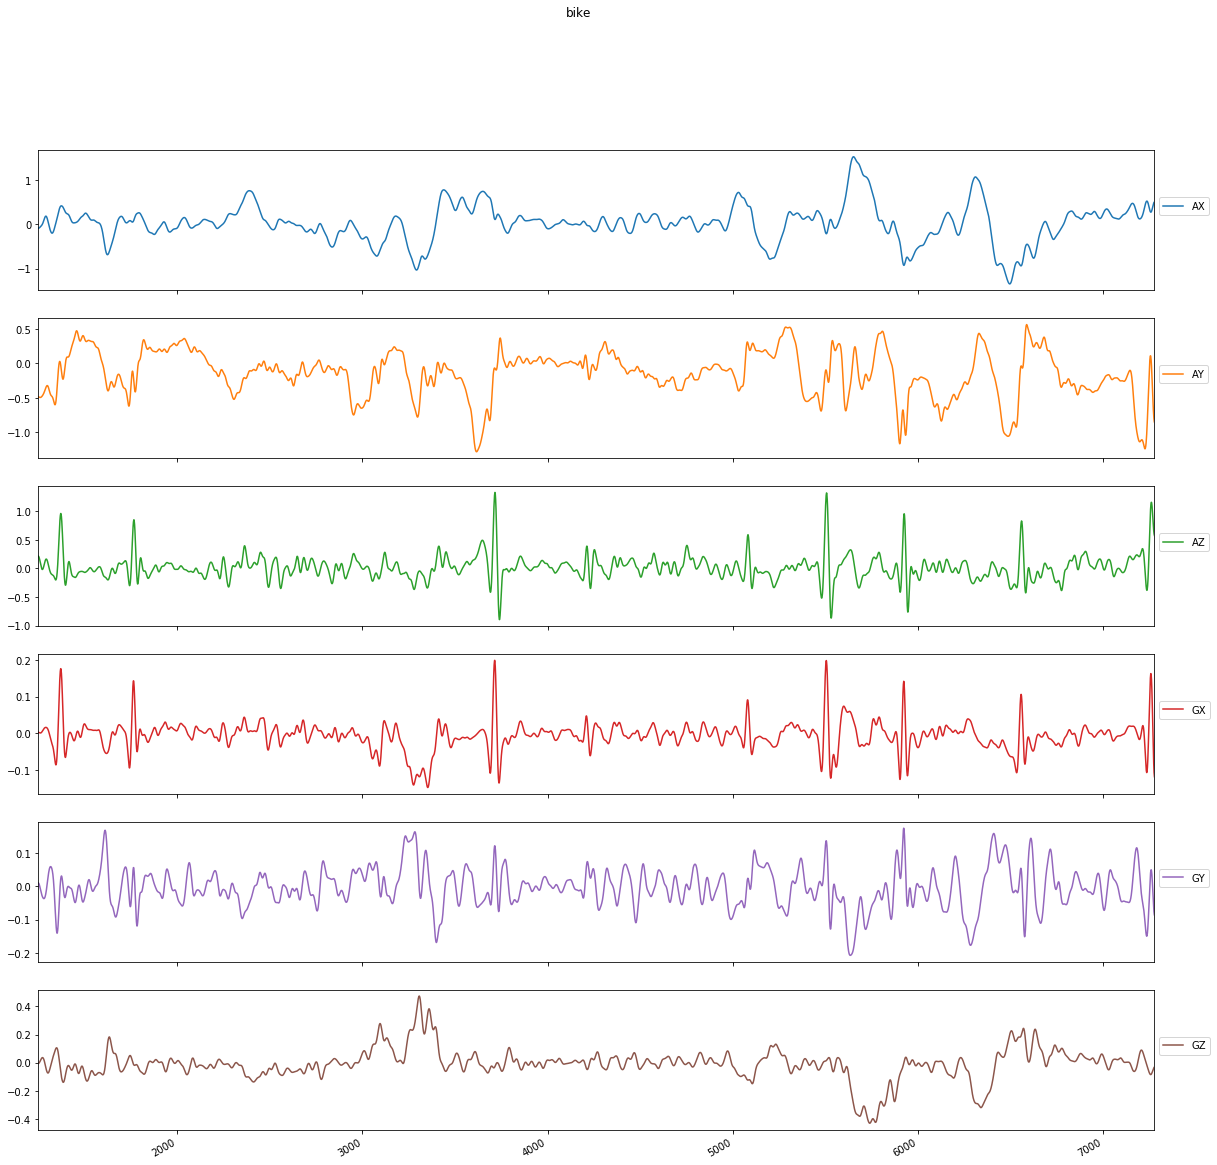

In [14]:
plot_transportation_mod('bike', df1)

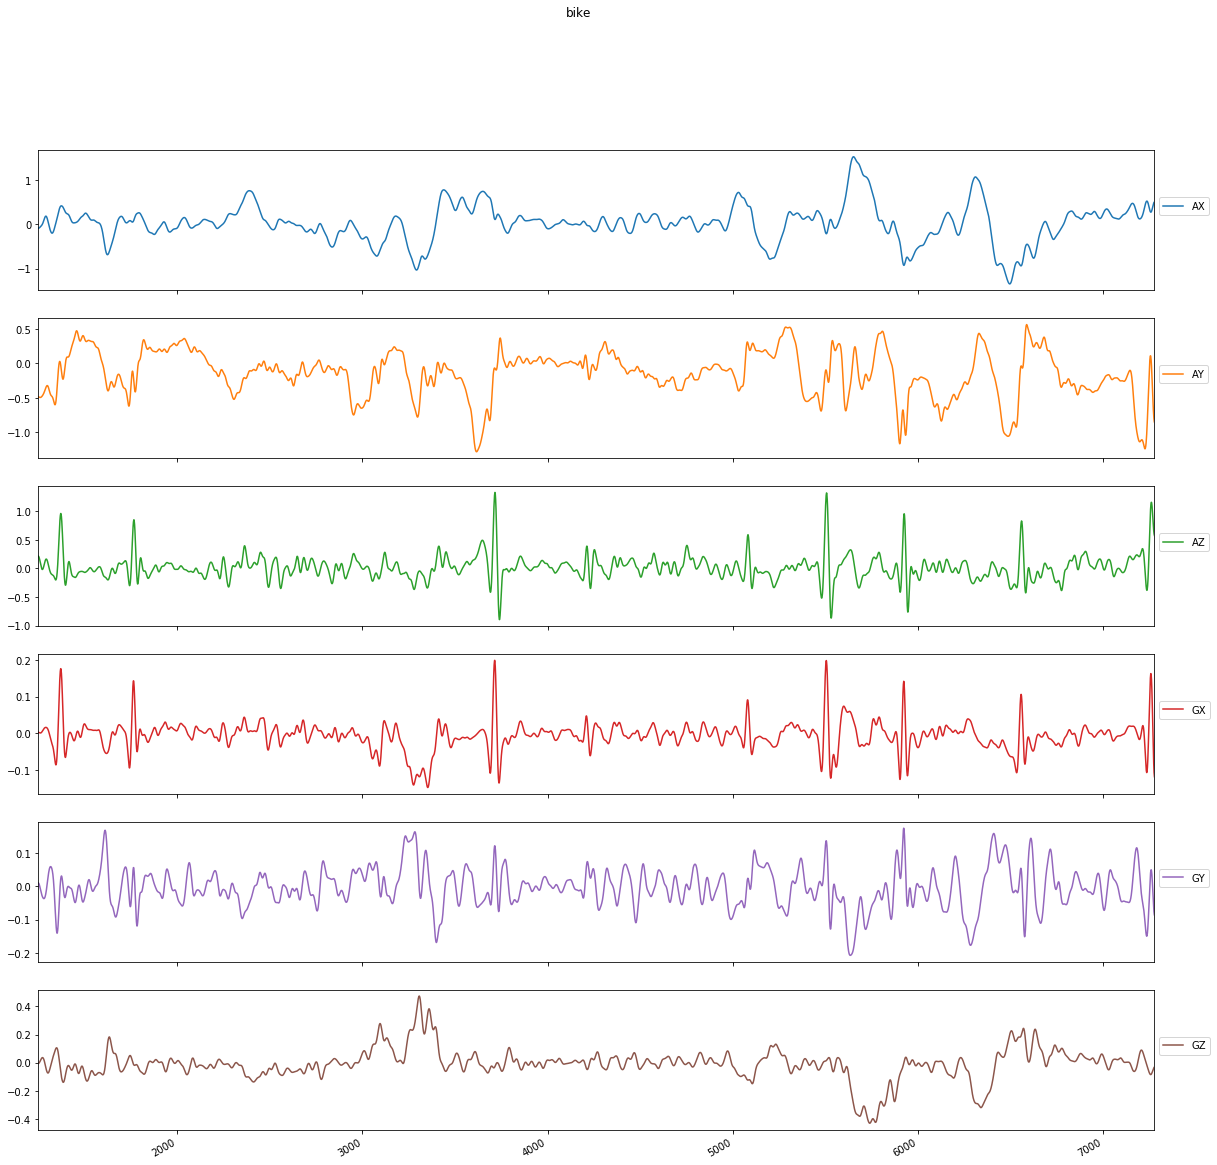

In [15]:
plot_transportation_mod('bike', df1)

In [16]:
def normalize(v, tolerance = 0.00001):
    msg2 = sum(n*n for n in v)
    if(abs(msg2-1.0)> tolerance):
        msg = np.sqrt(mag2)
        v = tuple(n/mag for n in v)
    return v


In [17]:
def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 + y1*w2 + z1*x2 - x1*z2
    z = w1*z2 + z1*w2 + x1*y2 - y1*x2
    
    return w, x, y, z


In [18]:
def q_conjugate(q):
    w, x, y, z = q;
    return (w, -x, -y, -z)


In [19]:
def qv_mult(q1, v1):
    q2 = (0.0, ) + v1
    return q_mult(q_mult(q1, q2), q_conjugate(q1))[1:]


In [20]:
def axisangle_to_q(v, theta):
    v = normalize(v)
    x, y, z = v
    theta = theta/2
    w = np.cos(theta)
    x = x*np.sin(theta)
    y = y*np.sin(theta)
    z = z*np.sin(theta)
    return w, x, y, z


In [21]:
def q_to_axisangle(q):
    w, v = q[0], q[1:]
    theta = np.acos(w)*2.0
    return normalize(v), theta

In [22]:
fftfeatures = []
features = ['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ']
for i in features:
    reals = np.real(np.fft.rfft(df[i]))
    imagn = np.imag(np.fft.rfft(df[i]))
    print(len(reals))
    complexs = [reals[0]]
    n = len(reals)
    if(n%2 == 0):
        complexs.append(imagn[0])
    for j in range(1, n-1):
        complexs.append(reals[j])
        complexs.append(imagn[j])
    complexs.append(reals[j])
    if( len(df) > len(complexs)):
        complexs.append(imagn[j])
    df['f'+i] = complexs
    print(len(complexs))
    fftfeatures.append('f'+i)


3015
6028
3015
6028
3015
6028
3015
6028
3015
6028
3015
6028


In [23]:
df['fAX'].shape

(6028,)

In [24]:
df.head()

,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,fAX,fAY,fAZ,fGX,fGY,fGZ
1250,25001,-0.086398,-0.486615,0.211049,0.002832,0.010466,-0.005226,bike,162.362563,-891.891484,80.903735,-35.490126,-22.843002,-54.141617
1251,25020,-0.085669,-0.486913,0.208489,0.002770,0.010068,-0.004817,bike,-73.764774,-86.369753,-20.476841,8.807053,-9.464648,-43.663125
1252,25041,-0.084217,-0.487497,0.203365,0.002655,0.009280,-0.004005,bike,50.045205,-68.826385,-39.148805,7.726937,-28.406841,-114.358060
1253,25060,-0.082094,-0.488325,0.195765,0.002489,0.008119,-0.002810,bike,118.818952,80.114834,104.234628,9.074522,13.133081,93.421366
1254,25080,-0.079384,-0.489315,0.185954,0.002284,0.006620,-0.001257,bike,-227.607253,-381.713925,-18.484752,-35.855603,20.508708,98.203082


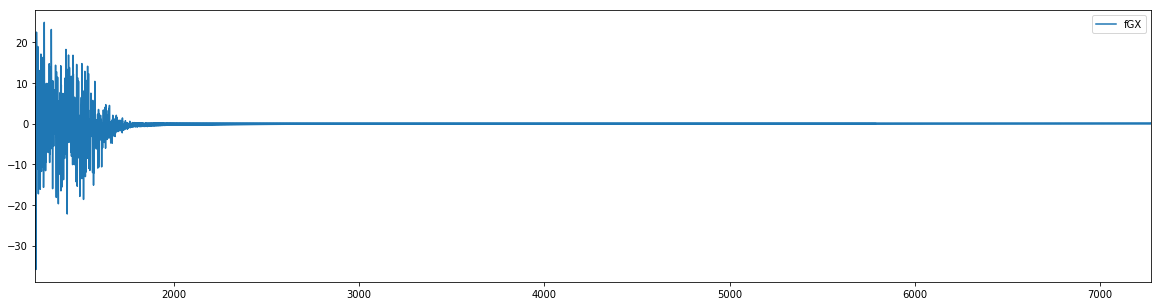

In [25]:
df[['fGX']].plot(figsize =(20,5))

In [26]:
# df['ffGX'] = np.fft.fft(df['GX'])


In [27]:
# df[['ffGX']].plot(figsize =(20,5))

In [90]:
def reoriente(df, features):
    window_size = 200
    
    df_x = df[features[0]].tolist()
    df_y = df[features[1]].tolist()
    df_z = df[features[2]].tolist()
    
    mean_ax = []
    mean_ay = []
    mean_az = []
    n = len(df)
    for k in range(0, window_size):
        mean_ax.append(0.0)
        mean_ay.append(0.0)
        mean_az.append(0.0)
    for i in range(0,n-window_size):
        sum_x = 0
        sum_y = 0
        sum_z = 0

        for k in range(0, window_size):
            sum_x = sum_x + df_x[i+k]
            sum_y = sum_y + df_y[i+k]
            sum_z = sum_z + df_z[i+k]            
            
        mean_x = sum_x/window_size
        mean_y = sum_y/window_size
        mean_z = sum_z/window_size
      
        mean_ax.append(mean_x)
        mean_ay.append(mean_y)
        mean_az.append(mean_z)
        
    for k in range(0, window_size):
        mean_ax.append(mean_x)
        mean_ay.append(mean_y)
        mean_az.append(mean_z)
    
    print(len(mean_ax))

    df['mean_ax'] = pd.Series(mean_ax)
    df['mean_ay'] = pd.Series(mean_ay)
    df['mean_az'] = pd.Series(mean_az)
    return mean_ax, mean_ay, mean_az

features = ['AX', 'AY', 'AZ']
mean_ax, mean_ay, mean_az = reoriente(df,features) 
df


6828


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,fAX,fAY,fAZ,fGX,fGY,fGZ,mean_ax,mean_ay,mean_az,az_rotated
1250,25001,-0.086398,-0.486615,0.211049,0.002832,0.010466,-0.005226,bike,162.362563,-891.891484,80.903735,-35.490126,-22.843002,-54.141617,0.401920,-0.181605,0.087602,0.138583
1251,25020,-0.085669,-0.486913,0.208489,0.002770,0.010068,-0.004817,bike,-73.764774,-86.369753,-20.476841,8.807053,-9.464648,-43.663125,0.400493,-0.179384,0.086187,0.104837
1252,25041,-0.084217,-0.487497,0.203365,0.002655,0.009280,-0.004005,bike,50.045205,-68.826385,-39.148805,7.726937,-28.406841,-114.358060,0.399042,-0.177147,0.084880,0.071852
1253,25060,-0.082094,-0.488325,0.195765,0.002489,0.008119,-0.002810,bike,118.818952,80.114834,104.234628,9.074522,13.133081,93.421366,0.397568,-0.174903,0.083692,0.040885
1254,25080,-0.079384,-0.489315,0.185954,0.002284,0.006620,-0.001257,bike,-227.607253,-381.713925,-18.484752,-35.855603,20.508708,98.203082,0.396071,-0.172665,0.082634,0.012988
1255,25101,-0.076178,-0.490368,0.174198,0.002053,0.004824,0.000620,bike,120.747283,-109.762248,50.660886,-17.356726,7.144680,91.521766,0.394553,-0.170441,0.081712,-0.011069
1256,25120,-0.072565,-0.491419,0.160734,0.001815,0.002776,0.002782,bike,-321.252566,-88.385611,-20.883186,-6.384213,26.255784,110.523457,0.393015,-0.168241,0.080929,-0.030827
1257,25140,-0.068637,-0.492372,0.145873,0.001589,0.000523,0.005183,bike,200.684865,-106.716833,86.260429,22.481473,-24.628891,-135.007696,0.391456,-0.166073,0.080283,-0.046136
1258,25161,-0.064491,-0.493114,0.129990,0.001389,-0.001886,0.007776,bike,408.524441,107.920209,49.655624,17.904968,-21.768939,-33.633861,0.389879,-0.163942,0.079770,-0.057119
1259,25180,-0.060220,-0.493559,0.113478,0.001234,-0.004401,0.010508,bike,418.723014,-387.331979,107.009513,13.378924,-27.996572,-99.009061,0.388286,-0.161854,0.079385,-0.064111


In [91]:
from math import *
az_rotated = []
for index, row in df.iterrows():
    x = row['mean_ax']
    y = row['mean_ay']
    z = row['mean_az']
    theta_x = degrees(atan((y**2/(x**2 + z**2)**(1/2))))
    theta_y = degrees(atan((x**2/(x**2 + z**2)**(1/2))))
    t = -x*sin(theta_x) + z*cos(theta_y)
    
    z_rotated = y*sin(theta_x) + t*cos(theta_x)
    az_rotated.append(z_rotated)

df['az_rotated'] = az_rotated
    
    

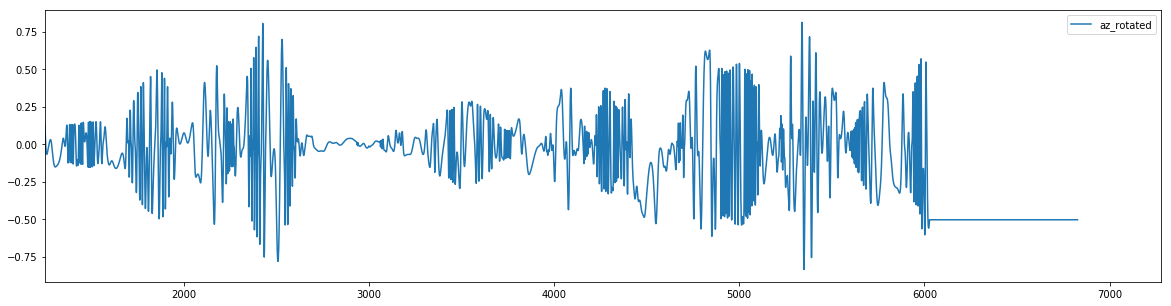

In [92]:
# df[['AZ']].plot(figsize =(20,5))
df[['az_rotated']].plot(figsize =(20,5))